# Compute information loss due to quantization

In this notebook, we compute the information loss resulting from quantization, computed as MSE and PSNR between original image and quantized one.


In [23]:
import numpy as np
import matplotlib.pyplot as plt

from quanvs.quanv_util import quantize_patch

from quanvs.quanv_util import default_encoding_config
from quanvs.Quanvolutional_Layer import QuanvolutionalLayer
from quanvs.model_builder import CNN
import constants

from quanvs.model_builder import stack_quanv_on_top
from quanvs.model_builder import get_default_model_config


config = get_default_model_config()
config["input_shape"] = (1, 30, 30)

print(config["input_shape"])

model = CNN(device="cpu", config=config)

print(model)


(1, 30, 30)
CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=7, bias=True)
)


To show the effect of quantization, we first plot some images from the CIFAR10 dataset with different levels of quantization.

7
1
1


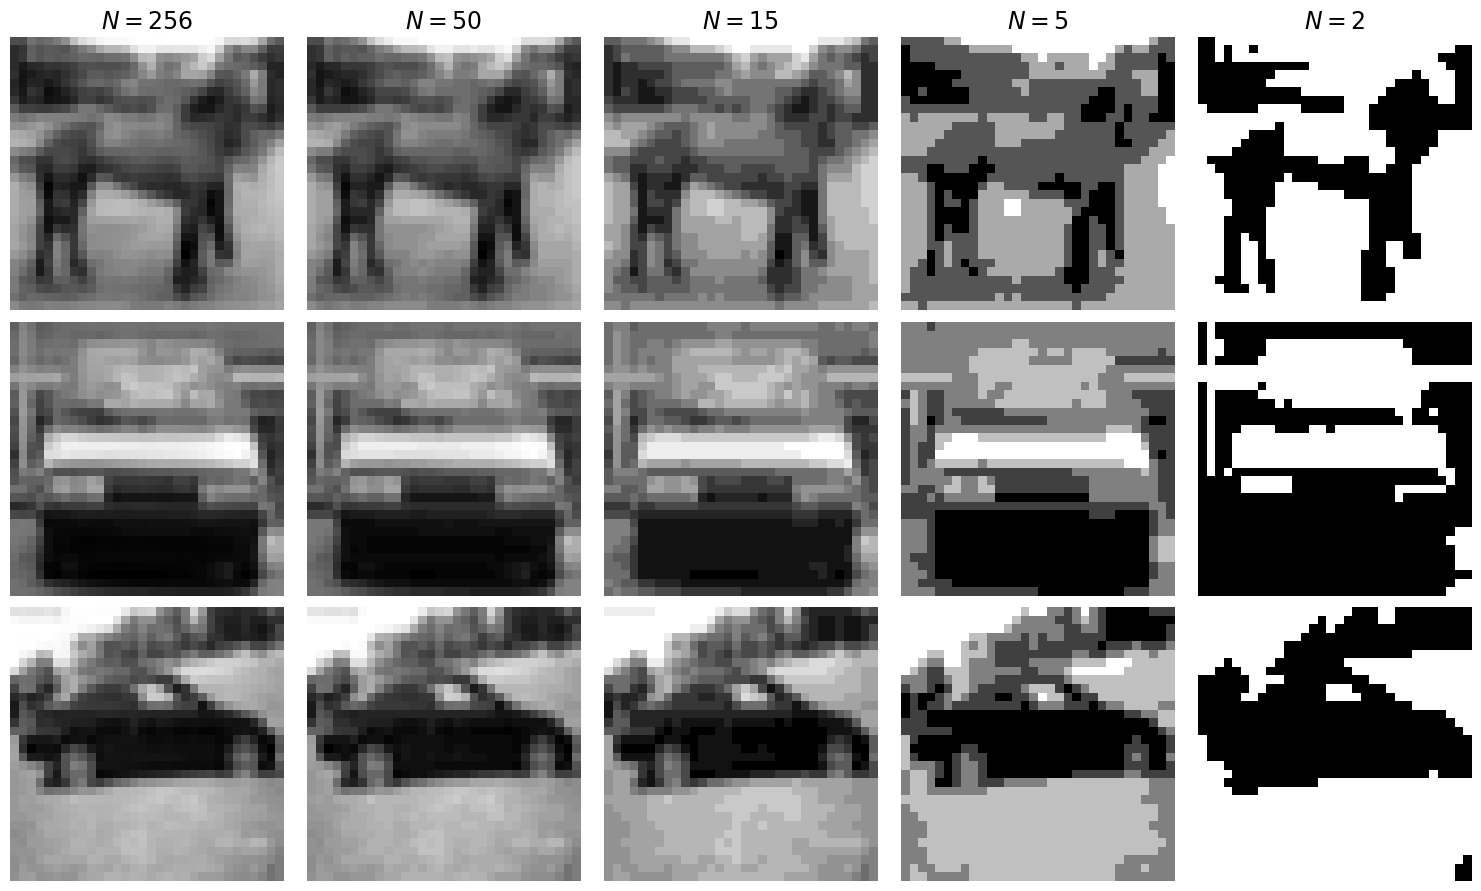

In [24]:
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)


levels = [256, 50, 15, 5, 2]

fig, axs = plt.subplots(3, len(levels), figsize=(15, 9))

image_count = 0

for data, target in tqdm(train_loader, leave=False):
    for image, label in zip(data, target):
        if image_count >= 3:
            break
        base_image = image[0].numpy()
        for i, N in enumerate(levels):
            discretized_image = quantize_patch(base_image.copy(), N)
            axs[image_count, i].imshow(discretized_image, cmap='gray')
            axs[image_count, i].axis('off')
            if image_count == 0:
                axs[image_count, i].set_title(f'$N = {N}$', fontsize=17)

        print(label.item())
        image_count += 1
    if image_count >= 3:
        break

plt.tight_layout()
plt.show()

For a comparison, images from MNIST show lower levels of perceived information loss.

6
6
8


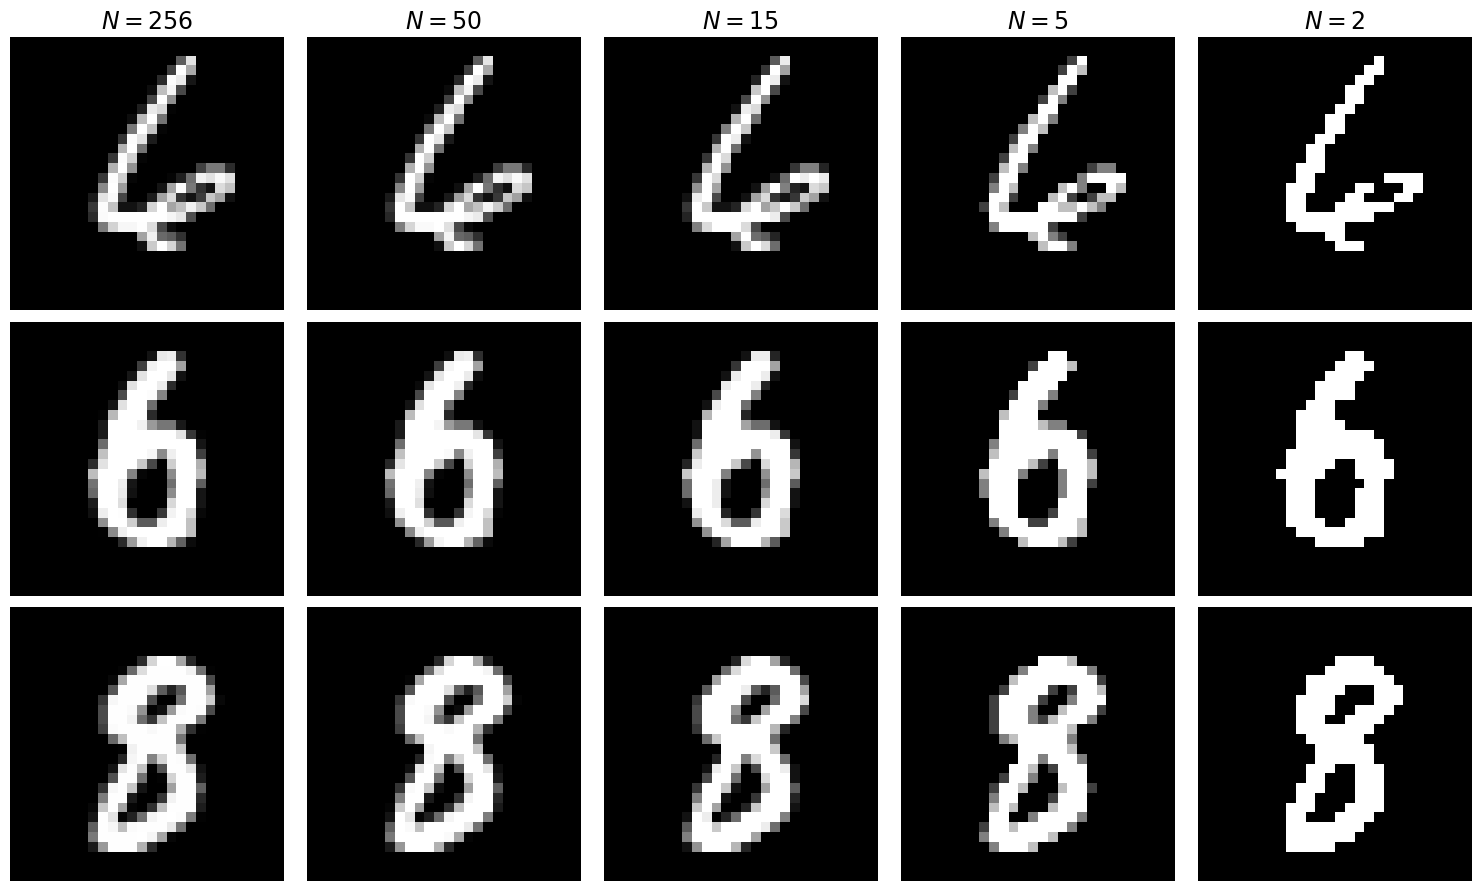

In [25]:
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)


levels = [256, 50, 15, 5, 2]

fig, axs = plt.subplots(3, len(levels), figsize=(15, 9))


image_count = 0

for data, target in tqdm(train_loader, leave=False):
    for image, label in zip(data, target):
        if image_count >= 3:
            break
        base_image = image[0].numpy()
        for i, N in enumerate(levels):
            discretized_image = quantize_patch(base_image.copy(), N)
            axs[image_count, i].imshow(discretized_image, cmap='gray')
            axs[image_count, i].axis('off')
            if image_count == 0:
                axs[image_count, i].set_title(f'$N = {N}$', fontsize=17)
        #axs[image_count, 0].set_ylabel(f'Class: {label.item()}', fontsize=16)
        print(label.item())
        image_count += 1
    if image_count >= 3:
        break

plt.tight_layout()
plt.show()

In [26]:
def measure_MSE(image1, image2):
    return ((image1 - image2) ** 2).mean()

def get_PSNR_from_MSE(mse, max_pixel=1):
    return 20 * np.log10(max_pixel / (np.sqrt(mse)+1e-10)) # 1e-10 to avoid division by zero

Given an image I and the corresponding version quantized to $N$ values, the difference between their pixels is less than $$\frac{1}{4(N-1)^2}.$$ This gives us a way to compute an upper bound to the MSE.

In [27]:
def analitic_maximal_MSE(N):
    return 1/(4*(N-1)**2)

def analitic_maximal_PSNR(N):
    return 10 * np.log10(4*(N-1)**2)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from utils.get_dataset.dataset_Mirabest import get_MiraBest_binary
from utils.get_dataset.dataset_LArTPC import get_LArTPC_full

def process_dataset(dataset_code, Ns):
    mean_MSEs = []
    mean_PSNRs = []

    
    if dataset_code == "LArTPC":
        train_loader, test_loader, info = get_LArTPC_full(downscale=True, autocrop=False)
        size = 30

    elif dataset_code == "MNIST":
        transform = transforms.Compose([transforms.ToTensor()])
        trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
        testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
        train_loader = DataLoader(trainset, batch_size=28, shuffle=True)
        test_loader = DataLoader(testset, batch_size=28, shuffle=True)
        size = 28

    elif dataset_code == "CIFAR10":
        transform = transforms.Compose([transforms.ToTensor()])
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
        train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
        test_loader = DataLoader(testset, batch_size=32, shuffle=True)
        size = 32

    elif dataset_code == "MiraBest":
        train_loader, test_loader, info = get_MiraBest_binary()
        size = 30


    elif dataset_code == "Analytic Expression":

        for N in tqdm(Ns, desc=f"Processing {dataset_code}"):
            MSEs = []
            PSNRs = []


            MSEs_array = np.array(MSEs)
            mean_MSEs.append(analitic_maximal_MSE(N))
            mean_PSNRs.append(analitic_maximal_PSNR(N))

        return mean_MSEs, mean_PSNRs


    for N in tqdm(Ns, desc=f"Processing {dataset_code}"):
        MSEs = []
        PSNRs = []

        for data, target in tqdm(train_loader, leave=False):
            for image in data:
                base_image = image[0].numpy()
                discretized_image = quantize_patch(base_image.copy(), N)
                MSE = measure_MSE(base_image, discretized_image)
                MSEs.append(MSE)
                PSNRs.append(get_PSNR_from_MSE(MSE))

        for data, target in test_loader:
            for image in data:
                base_image = image[0].numpy()
                discretized_image = quantize_patch(base_image.copy(), N)
                MSE = measure_MSE(base_image, discretized_image)
                MSEs.append(MSE)
                PSNRs.append(get_PSNR_from_MSE(MSE))

        MSEs_array = np.array(MSEs)
        mean_MSEs.append(MSEs_array.mean())
        mean_PSNRs.append(np.array(PSNRs).mean())

    return mean_MSEs, mean_PSNRs

In [29]:
datasets = ["Analytic Expression", "LArTPC", "MNIST", "CIFAR10", "MiraBest"]

Ns = [2, 3, 5, 10, 15, 20, 30, 40, 50, 75, 100]

results = {}
for dataset in datasets:
   results[dataset] = process_dataset(dataset, Ns)



Processing Analytic Expression: 100%|██████████| 11/11 [00:00<00:00, 59918.63it/s]


700


Processing MiraBest: 100%|██████████| 11/11 [00:48<00:00,  4.41s/it]


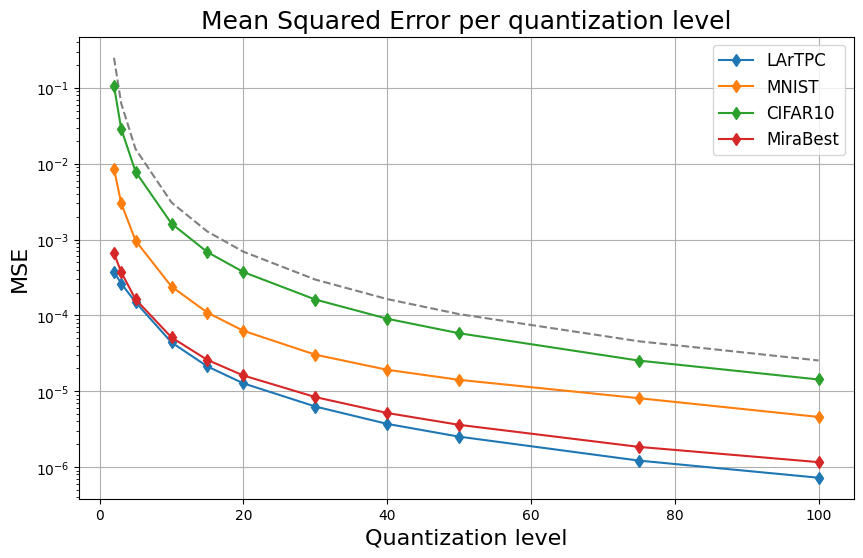

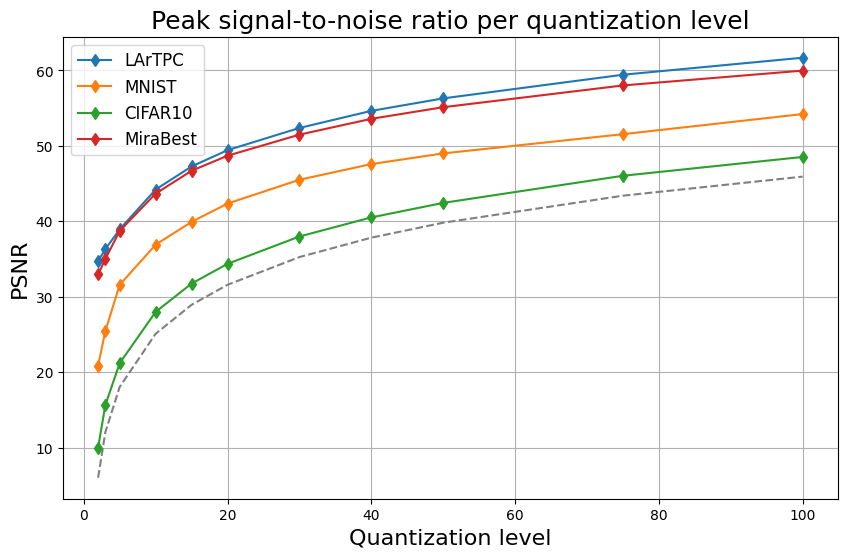

In [34]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
for dataset, (mean_MSEs, _) in results.items():
    if dataset == "Analytic Expression":
        label = 'Maximal MSE'
        plt.plot(Ns, mean_MSEs, label=None, linestyle='--', color='grey')
    else:
        label = f'{dataset}'
        plt.plot(Ns, mean_MSEs, marker='d',  label=label)

plt.yscale('log')
plt.xlabel('Quantization level', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.title('Mean Squared Error per quantization level', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)

plt.savefig('MSE.pdf')
plt.show()

# Plot PSNR results
plt.figure(figsize=(10, 6))
for dataset, (_, mean_PSNRs) in results.items():
    if dataset == "Analytic Expression":
        label = 'Minimal PSNR'
        plt.plot(Ns, mean_PSNRs, label=None, linestyle='--', color='grey')
    else:
        label = f'{dataset}'
        plt.plot(Ns, mean_PSNRs, marker='d', label=label)

plt.xlabel('Quantization level', fontsize=16)
plt.ylabel('PSNR', fontsize=16)
plt.title('Peak signal-to-noise ratio per quantization level', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)

plt.savefig('PSNR.pdf')
plt.show()
